# Nonlinear Programming Using scipy.optimize

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from scipy.optimize import minimize, LinearConstraint

## Problem Structure
- Nonlinear Objective
- 2 Nonliear Constraints

In [3]:
def objective(x):
    return x[0] * x[3] * ( x[0] + x[1] + x[2] ) + x[2]

def constraint1(x, lower_lim=25.0):
    # Inequality Constraint: Prod(x) >= lower_lim
    return np.prod(x) - lower_lim

def constraint2(x, upper_lim=40.0):
    # Equality Constraint
    return upper_lim - np.sum(x**2)

## Initial Solution

Guessed at

In [4]:
# initial guesses
x0 = np.array([1.0, 4.0, 5.0, 1.5])

# show initial objective
print('Initial SSE Objective:   ' + str(objective(x0)))
print('Initial SSE Constraint1: ' + str(constraint1(x0)))
print('Initial SSE Constraint2: ' + str(constraint2(x0)))

# print solution
print('\nInitial Solution:', ", ".join("%.3f" % v for v in x0))

Initial SSE Objective:   20.0
Initial SSE Constraint1: 5.0
Initial SSE Constraint2: -4.25

Initial Solution: 1.000, 4.000, 5.000, 1.500


## Calling Minimize Function
- Define Decision Variable Bounds
- Define Constraints
    - Constraint 1: Inequality Constraint (needs to be non-negative)
    - Constraint 2: Equality Constraint

In [5]:
b = (1.0,5.0)
bnds = (b, b, b, b)

In [6]:
con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'eq', 'fun': constraint2}
cons = ([con1,con2])

Time to complete optimization for 5 separate starting points

In [7]:
%%time
np.random.seed(20)
for jitter in np.random.normal(0,5,(5,4)):
    solution = minimize(objective, x0+jitter, method='SLSQP',
                        bounds=bnds, constraints=cons,  tol=1e-12, options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17.014017289156243
            Iterations: 14
            Function evaluations: 84
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17.014017289156072
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17.014017289156
            Iterations: 9
            Function evaluations: 56
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 27.14642819948225
            Iterations: 14
            Function evaluations: 115
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 17.014017289155724
            Iterations: 22
            Function evalu

In [8]:
# show final objective (using last set of results)

print("Exit Code = %d" % solution.status)
print("Solution Success: %s" % solution.success)
print("Solution Message: %s\n" % solution.message)

print('Final SSE Objective:   %.3f' % solution.fun)
print('Final SSE Constraint1: %.3g' % constraint1(solution.x))
print('Final SSE Constraint2: %.3g' % constraint2(solution.x))
print("\n")

print('Final Solution:', ", ".join("%.3f" % v for v in solution.x))

Exit Code = 0
Solution Success: True
Solution Message: Optimization terminated successfully.

Final SSE Objective:   17.014
Final SSE Constraint1: -7.85e-13
Final SSE Constraint2: -8.81e-13


Final Solution: 1.000, 4.743, 3.821, 1.379


### Marginal Effects Around Optimum

In [9]:
prob_fun = [{'type': 'obj', 'fun':objective}] + cons

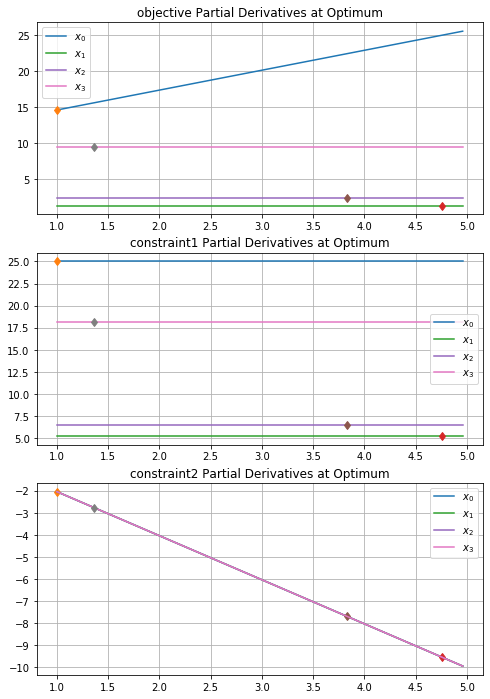

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(8,12))
n = 100

for i, b in enumerate(bnds):
    x_ = np.linspace(*b,n)
    x1 = np.broadcast_to(solution.x,(n,len(solution.x))).copy()
    x1[:,i] = x_
    lbl = r"$x_%d$" % i
    dx = x_[1:] - x_[:-1]
    for j,fn in enumerate(prob_fun):
        pfeval = np.apply_along_axis(fn['fun'],1,x1)
        dy = pfeval[1:] - pfeval[:-1]
        axs[j].plot(x_[:-1],dy/dx,label=lbl)
        x0pos = np.argmin(np.abs(x_[:-1]-solution.x[i]))
        axs[j].plot(x_[x0pos],(dy/dx)[x0pos],'d')

for j,fn in enumerate(prob_fun):
    ft = fn['fun'].__name__
    axs[j].set_title(ft + " Partial Derivatives at Optimum")
    axs[j].legend()
    axs[j].grid()
    
plt.show()

Consider strategies to minimize the objective:
- Reduce $x_0$, but we are already at the lower bound.
- Reduce $x_3$ and the objective by $~10 \times dx_3$, but a ~30% smaller increase in $x_0$ is required to maintain the equality constraint (2). The net effect is ~0 as the objective is increased by $~15 \times dx_0$. The same results are obtained if one counterbalances the decrease in $x_3$ by increases in $x_1$ or $x_2$.

## Naive Alternative: Evaluation at Random Points

In [11]:
%%time

# Evaluation at Random Points Within Bounds
np.random.seed(2020)
xr = np.array([np.random.uniform(*b,int(1e6)) for b in bnds])
xr.shape

Wall time: 111 ms


(4, 1000000)

To optimize evaluation, follow this plan:

- Evaluate Constraint 2 (Equality Constraint)
- Evaluate Constraint 1
- Evaluate Objective

In [12]:
%%time

rand_eval = np.abs(np.apply_along_axis(constraint2,0,xr)) < 0.1  # Equality Constraint

c2ratio = np.mean(rand_eval)
print("Constraint 2 Feasible in {:.2%} of Cases".format(c2ratio))

xr = xr[:,rand_eval]

Constraint 2 Feasible in 0.54% of Cases
Wall time: 8.96 s


In [13]:
%%time

rand_eval = np.apply_along_axis(constraint1,0,xr) >= 0   # Inequality Constraint

c1ratio = np.mean(rand_eval)
print("Constraint 1 Feasible in {:.2%} of Remaining Cases".format(c1ratio))
print("Both Constraints Feasible in {:.2%} of Cases".format(c1ratio*c2ratio))

xr = xr[:,rand_eval]

Constraint 1 Feasible in 99.04% of Remaining Cases
Both Constraints Feasible in 0.54% of Cases
Wall time: 64 ms


Wall time: 38 ms


Text(0.5, 1.0, 'Objective Evaluated at Randomly Selected Feasible Points')

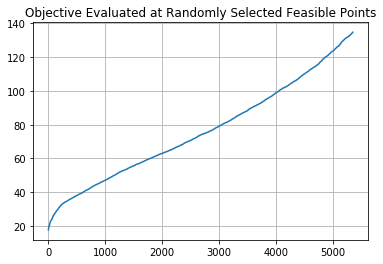

In [14]:
%%time

o = np.apply_along_axis(objective,0,xr)
plt.plot(sorted(o))
plt.grid()
plt.title("Objective Evaluated at Randomly Selected Feasible Points");

In [15]:
xb = xr[:,np.argmin(o)]

In [17]:
# show final objective
print('Random Search SSE Objective:   %.3f' % objective(xb))
print('Random Search SSE Constraint1: %.3g' % constraint1(xb))
print('Random Search SSE Constraint2: %.3g\n' % constraint2(xb))

# print solution
print('Random Search Solution:', ", ".join("%.3f" % v for v in xb))

Random Search SSE Objective:   17.783
Random Search SSE Constraint1: 0.768
Random Search SSE Constraint2: 0.0602

Random Search Solution: 1.231, 4.864, 3.658, 1.176


**This approach takes much longer and produces an inferior solution.**